In [141]:
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
from datetime import datetime
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np

In [69]:
data = pd.read_csv("nasdaq_symbols.csv") 
# Preview the first 5 lines of the loaded data 
#data.head()
ticker_symbols = data['Symbol']
ticker_symbols

0       AAIT
1        AAL
2       AAME
3       AAOI
4       AAON
        ... 
2962      ZN
2963    ZNGA
2964    ZSPH
2965      ZU
2966    ZUMZ
Name: Symbol, Length: 2967, dtype: object

In [70]:
# Only work on a subset of data - for testing:
ticker_symbols=ticker_symbols[0:4]
ticker_symbols

0    AAIT
1     AAL
2    AAME
3    AAOI
Name: Symbol, dtype: object

In [71]:
singleTickerTest = False
#singleTickerTest = True

# This is only for testing a single ticker-symbol, outside a loop:
if singleTickerTest:
    t = 'AAPL'
    yf = YahooFinancials(t)

    # Collect data - the more, the better for creating features for machine learning algorithms:
    historical_stock_prices = yf.get_historical_price_data('2021-01-01', '2021-04-04', 'daily')
    balance_sheet_data = yf.get_financial_stmts('quarterly', 'balance')
    income_statement_data = yf.get_financial_stmts('quarterly', 'income')
    all_statement_data =  yf.get_financial_stmts('quarterly', ['income', 'cash', 'balance'])
    earnings_data = yf.get_stock_earnings_data()
    net_income = yf.get_net_income()

    # Assembly into dict (ctrl+"/" in Jupyter notebook to comment/uncomment):
    stock_dict = {
        'historical_stock_prices': historical_stock_prices,
        'balance_sheet_data': balance_sheet_data,
        'income_statement_data': income_statement_data,
        'all_statement_data': all_statement_data,
        'earnings_data': earnings_data,
        'net_income': net_income }

In [72]:
# View data:
if singleTickerTest:
    print(stock_dict)
    #---
    #historical_stock_prices
    #balance_sheet_data
    #income_statement_data
    #all_statement_data
    #earnings_data
    #net_income

In [76]:
start='2021-01-01'
end='2021-04-04'

stock_dict = {}

for t in ticker_symbols:
    print(t)
    
    yf = YahooFinancials(t)
    
    # Collect data - the more, the better for creating features for machine learning algorithms:
    historical_stock_prices = yf.get_historical_price_data(start, end, 'daily')
    #balance_sheet_data = yf.get_financial_stmts('quarterly', 'balance')
    #income_statement_data = yf.get_financial_stmts('quarterly', 'income')
    #all_statement_data =  yf.get_financial_stmts('quarterly', ['income', 'cash', 'balance'])
    #earnings_data = yf.get_stock_earnings_data()
    #net_income = yf.get_net_income()

    # Assembly into dict:
    stock_dict[t] = {
        'historical_stock_prices': historical_stock_prices,
        #'balance_sheet_data': balance_sheet_data,
        #'income_statement_data': income_statement_data,
        #'all_statement_data': all_statement_data,
        #'earnings_data': earnings_data,
        #'net_income': net_income
    }

AAIT
AAL
AAME
AAOI


In [117]:
#stock_dict['AAIT']
def get_stock_data(ticker):
    df=pd.DataFrame(columns=["open","close","adjclose"])
    for row in stock_dict[ticker]['historical_stock_prices'][ticker]['prices']:
        date = datetime.fromisoformat(row["formatted_date"])
        df.loc[date] = [row["open"], row["close"], row["adjclose"]]
    df.index.name = "date"
    return df

In [ ]:
#Testing:
#test=stock_dict['AAL']['historical_stock_prices']
#test
#test['AAL']['prices']
#test=stock_dict['AAL']['historical_stock_prices']['AAL']['prices']
#test['currency']
#test['prices']
#test=get_stock_data('AAIT')
#test

In [124]:
testplot = get_stock_data('AAIT')


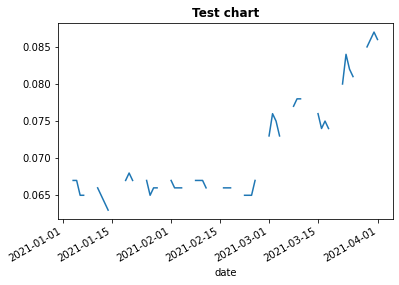

In [125]:
fig = plt.figure()
testplot["adjclose"].plot()
plt.title("Test chart", weight="bold");

Text(0.5, 1.0, 'Daily returns')

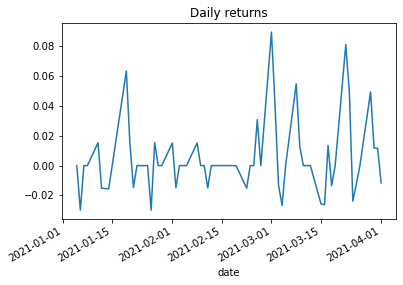

In [127]:
# Daily returns:
testplot["adjclose"].pct_change().plot()
plt.title("Daily returns")

Text(0.5, 1.0, 'Histogram of daily returns')

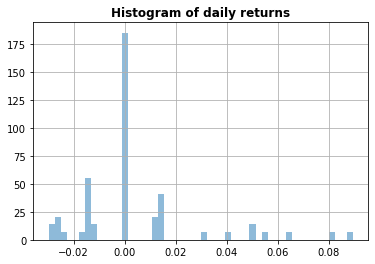

In [131]:
# Histogram:
testplot["adjclose"].pct_change().hist(bins=50, density=True, histtype="stepfilled", alpha=0.5)
plt.title("Histogram of daily returns", weight="bold")

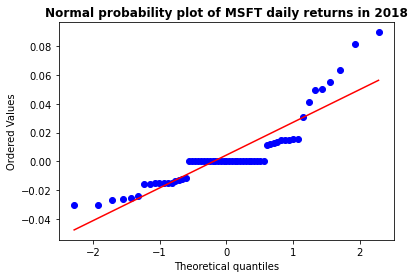

In [134]:
Q = testplot["adjclose"].pct_change().dropna()
scipy.stats.probplot(Q, dist=scipy.stats.norm, plot=plt.figure().add_subplot(111))
plt.title("Normal probability plot of MSFT daily returns in 2018", weight="bold");

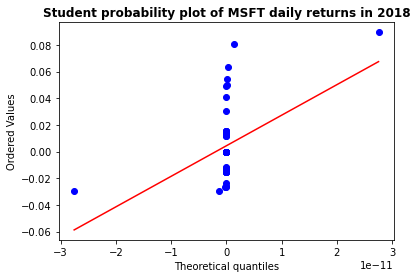

In [135]:
# Student’s t distribution:
tdf, tmean, tsigma = scipy.stats.t.fit(Q)
scipy.stats.probplot(Q, dist=scipy.stats.t, sparams=(tdf, tmean, tsigma), plot=plt.figure().add_subplot(111))
plt.title("Student probability plot of daily returns", weight="bold");

-0.026315745616387054

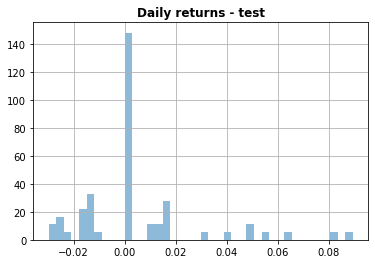

In [138]:
returns = testplot["adjclose"].pct_change().dropna()
mean = returns.mean()
sigma = returns.std()
tdf, tmean, tsigma = scipy.stats.t.fit(returns)
returns.hist(bins=40, density=True, histtype="stepfilled", alpha=0.5)
plt.title("Daily returns - test", weight="bold");

# The 0.05 empirical quantile of daily returns is at -0.026.
# (with 95% confidence, the worst daily loss will not exceed 2.6%).
returns.quantile(0.05)

-0.03614971142733721

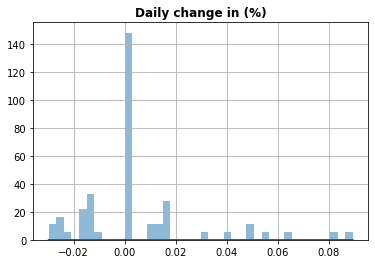

In [145]:
support = np.linspace(returns.min(), returns.max(), 100)
returns.hist(bins=40, density=True, histtype="stepfilled", alpha=0.5);
plt.plot(support, scipy.stats.t.pdf(support, loc=tmean, scale=tsigma, df=tdf), "r-")
plt.title("Daily change in (%)", weight="bold");

# Analytic 0.05 quantile is at -3.6%.
scipy.stats.norm.ppf(0.05, mean, sigma)

In [ ]:
# Optionally: Correlation between stocks.
# Todo: Add other data providers than yahoo finance: e.g. google finance/whatever